In [8]:
import os
import dgl
import time
import torch
import seaborn
import pandas as pd
import numpy as np
from tqdm import tqdm
import argparse
from warnings import simplefilter
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from torch.utils.data import TensorDataset
# from load_data import load_data, load_graph, remove_graph
#     get_data_loaders,, topk_filtering
from load_data import topk_filtering
from model import Model
from utils import get_metrics, get_metrics_auc, set_seed, \
    plot_result_auc, plot_result_aupr, checkpoint

In [3]:
def load_data(dataset, k):
    drug_drug = pd.read_csv('./dataset/{}/drug_drug.csv'.format(dataset), header=None)
    drug_drug_link = topk_filtering(drug_drug.values, k)
    disease_disease = pd.read_csv('./dataset/{}/disease_disease.csv'.format(dataset), header=None)
    disease_disease_link = topk_filtering(disease_disease.values, k)
    drug_disease = pd.read_csv('./dataset/{}/drug_disease.csv'.format(dataset), header=None)
    drug_disease_link = np.array(np.where(drug_disease == 1)).T
    disease_drug_link = np.array(np.where(drug_disease.T == 1)).T
    links = {'drug-drug': drug_drug_link, 'drug-disease': drug_disease_link,
             'disease-disease': disease_disease_link}
    graph_data = {('drug', 'drug-drug', 'drug'): (torch.tensor(drug_drug_link[:, 0]),
                                                  torch.tensor(drug_drug_link[:, 1])),
                  ('drug', 'drug-disease', 'disease'): (torch.tensor(drug_disease_link[:, 0]),
                                                        torch.tensor(drug_disease_link[:, 1])),
                  ('disease', 'disease-drug', 'drug'): (torch.tensor(disease_drug_link[:, 0]),
                                                        torch.tensor(disease_drug_link[:, 1])),
                  ('disease', 'disease-disease', 'disease'): (torch.tensor(disease_disease_link[:, 0]),
                                                              torch.tensor(disease_disease_link[:, 1]))}
    g = dgl.heterograph(graph_data)
    drug_feature = np.hstack((drug_drug.values, np.zeros(drug_disease.shape)))
    dis_feature = np.hstack((np.zeros(drug_disease.T.shape), disease_disease.values))
    g.nodes['drug'].data['h'] = torch.from_numpy(drug_feature).to(torch.float32)
    g.nodes['disease'].data['h'] = torch.from_numpy(dis_feature).to(torch.float32)
    if '{}_temp_{}k'.format(dataset, k) in os.listdir():
        print('Load data and label(It takes time)...')
        data = np.load('{}_temp_{}k/data.npy'.format(dataset, k))
        label = np.load('{}_temp_{}k/label.npy'.format(dataset, k))
    print('Data prepared !')
    return g, data, label

In [4]:
# Some settings to load the pre-trained model with accurate path
seed = 0
batch_size = 1024
k = 5
nfold = 5
aggregate_type = 'BiTrans'
hidden_feats = 128
learning_rate = 0.001
epoch = 2000
topk = 3
num_layer = 1
dropout = 0.4
batch_norm = False
path = 'result/C-dataset'
# Define the query dataset, drug, and disease
dataset = 'C-dataset'
drug_id = 241
disease_id = 280

Load data and label(It takes time)...
Data prepared !


No handles with labels found to put in legend.


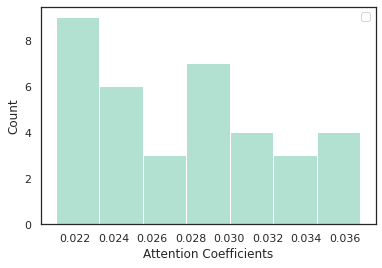

Top5 Attentions: [0.03501033 0.03501033 0.03318125 0.03022725 0.03003906]
Top5 Meta-path Instances:


array([[241,  15, 280, 280],
       [241,  15, 280, 280],
       [241, 143,  25, 280],
       [241, 281,  25, 280],
       [241,  33,  25, 280]])

In [12]:
# Load data
g, data, label = load_data(dataset, k)
data = torch.tensor(data)
label = torch.tensor(label)
feature = {'drug': g.nodes['drug'].data['h'],
           'disease': g.nodes['disease'].data['h']}
# Load pre-trained MilGNet model
model_d = []
attns = []
for idx in range(nfold):
    model = Model(g.etypes,
            {'drug': feature['drug'].shape[1], 
             'disease': feature['disease'].shape[1]},
                      hidden_feats=hidden_feats,
                      num_emb_layers=num_layer,
                      agg_type=aggregate_type,
                      dropout=dropout,
                      bn=batch_norm,
                      k=topk)
    model.load_state_dict(
        torch.load('result/C-dataset/'
                   f'k{k}_topk{topk}_nl{num_layer}_ep{epoch}_'
                   f'lr{learning_rate}_dp{dropout}_bs{batch_size}_'
                   f'hf{hidden_feats}_{seed}/model_{idx+1}.pkl'))
    model_d.append(model)
# Define the data to be used for generating the instance attentions
pred_data = data[(drug_id)*g.num_nodes('disease')+
                 disease_id].unsqueeze(dim=0)
attns = np.zeros(k*k+2*k+1)
for model in model_d:
    model.eval()
    pred, attn = model(g, feature, pred_data)
    attns += attn.detach().numpy().squeeze() / nfold
# Visualize the attention coefficient distribution   
seaborn.set(style='white')
seaborn.histplot(attn.detach().numpy()[0], palette='Set2')
plt.xlabel('Attention Coefficients')
plt.legend()
plt.show()
# Inferences for the topK meta-path instances
topk_idx = np.argsort(attns)[-5:][::-1]
print('Top5 Attentions: {}'.format(attns[topk_idx]))
print('Top5 Meta-path Instances:')
metapath = pred_data.numpy().squeeze()
attncoef = attn.detach().numpy()[0]
pred_data.numpy().squeeze()[topk_idx]

In [14]:
# Ensemble all generated meta-path instances
# and their attention attention coefficients
dr = pd.read_csv(f'dataset/{dataset}/drug.csv')
di = pd.read_csv(f'dataset/{dataset}/disease.csv')
mpac = []
for i in range(len(metapath)):
    new = []
    for j in range(2):
        new.append(dr.loc[metapath[i, j]].values[1])
    for j in range(2, 4):
        new.append(di.loc[metapath[i, j]].values[1])
    new.append(attncoef[i][0])
    mpac.append(new)
df_mp = pd.DataFrame(np.array(mpac),
                     columns=['Drug1', 'Drug2', 
                              'Disease1', 'Disease2', 'Attn'])
df_mp['Attn'] = df_mp['Attn'].astype(float)
df_mp = df_mp.sort_values(by='Attn', ascending=False)
df_mp

,Drug1,Drug2,Disease1,Disease2,Attn
16,DB00563,DB00158,D608456,D276300,0.036804
1,DB00563,DB00158,D276300,D276300,0.035363
15,DB00563,DB00158,D276300,D276300,0.035363
32,DB00563,DB00642,D114500,D276300,0.035153
14,DB00563,DB00158,D175100,D276300,0.034215
6,DB00563,DB00650,D276300,D276300,0.033997
12,DB00563,DB00158,D114500,D276300,0.033320
3,DB00563,DB00384,D276300,D276300,0.032033
25,DB00563,DB00384,D276300,D276300,0.032033
17,DB00563,DB00188,D114500,D276300,0.030808
